# 앙상블 모델
- LinearRegression 은 성능이 너무 안좋아서 제외함.

In [240]:
# !pip install eli5==0.13.0

# # 한글 폰트 사용을 위한 라이브러리입니다.
# !apt-get install -y fonts-nanum

In [241]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [242]:
# 앙상블시 모델별 가중치를 사용할지
IS_USE_WEIGHT = False

# train 셋 일부를 valid 셋으로 사용 여부
IS_USE_VALID = True

# 사용하려는 모델
IS_USE_RandomForest = False
IS_USE_GradientBoosting = False
IS_USE_LightGBM = True
IS_USE_XGBoost = True
IS_USE_LinearRegression = False

In [243]:
train_path = '../train_add_newXY.csv'
test_path  = '../test_add_newXY.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [244]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', df_train.shape, 'Test data shape : ', df_test.shape)

Train data shape :  (1118822, 54) Test data shape :  (9272, 53)


In [245]:
df_train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '좌표X_2', '좌표Y_2'],
      dtype='object')

### train, test 셋을 합쳐서 전처리 작업

In [246]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
df_train['is_test'] = 0
df_test['is_test'] = 1
df_concat = pd.concat([df_train, df_test])     # 하나의 데이터로 만들어줍니다.
df_concat.reset_index(drop=True, inplace=True)
df_concat

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,좌표X_2,좌표Y_2,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,127.056859,37.476276,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,127.056859,37.476276,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,127.056859,37.476276,0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,127.056859,37.476276,0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,127.056859,37.476276,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,127.106467,37.617195,1
1128090,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,127.106467,37.617195,1
1128091,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,127.106467,37.617195,1
1128092,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,127.106467,37.617195,1


### 사용 안하는 컬럼 삭제

In [247]:
df_concat.drop(columns=['본번', '부번', '아파트명', '층', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 
                        'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
                        'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법',
                        '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일'], inplace=True)
df_concat.columns

Index(['시군구', '번지', '전용면적(㎡)', '계약년월', '계약일', '건축년도', 'target', '좌표X_2',
       '좌표Y_2', 'is_test'],
      dtype='object')

### 컬럼명 변경

In [248]:
df_concat.rename(columns={'전용면적(㎡)':'전용면적'}, inplace=True)
df_concat.columns

Index(['시군구', '번지', '전용면적', '계약년월', '계약일', '건축년도', 'target', '좌표X_2', '좌표Y_2',
       'is_test'],
      dtype='object')

### 최단거리 초등학교 정보 붙이기


In [249]:
df_elem_train = pd.read_csv('elemSchool_for_train.csv')
df_elem_test = pd.read_csv('elemSchool_for_test.csv')
df_elem_concat = pd.concat([df_elem_train, df_elem_test])
df_elem_concat.reset_index(drop=True, inplace=True)
df_elem_concat

,최단거리초등학교명,최단거리초등학교Km
0,서울포이초등학교,0.385832
1,서울포이초등학교,0.385832
2,서울포이초등학교,0.385832
3,서울포이초등학교,0.385832
4,서울포이초등학교,0.385832
...,...,...
1128089,서울새솔초등학교,0.437157
1128090,서울새솔초등학교,0.437157
1128091,서울새솔초등학교,0.437157
1128092,서울새솔초등학교,0.437157


In [250]:
df_concat = pd.concat([df_concat, df_elem_concat], axis=1)

del df_elem_train
del df_elem_test
del df_elem_concat

df_concat

,시군구,번지,전용면적,계약년월,계약일,건축년도,target,좌표X_2,좌표Y_2,is_test,최단거리초등학교명,최단거리초등학교Km
0,서울특별시 강남구 개포동,658-1,79.97,201712,8,1987,124000.0,127.056859,37.476276,0,서울포이초등학교,0.385832
1,서울특별시 강남구 개포동,658-1,79.97,201712,22,1987,123500.0,127.056859,37.476276,0,서울포이초등학교,0.385832
2,서울특별시 강남구 개포동,658-1,54.98,201712,28,1987,91500.0,127.056859,37.476276,0,서울포이초등학교,0.385832
3,서울특별시 강남구 개포동,658-1,79.97,201801,3,1987,130000.0,127.056859,37.476276,0,서울포이초등학교,0.385832
4,서울특별시 강남구 개포동,658-1,79.97,201801,8,1987,117000.0,127.056859,37.476276,0,서울포이초등학교,0.385832
...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,84.65,202307,19,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157
1128090,서울특별시 중랑구 신내동,816,84.62,202307,25,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157
1128091,서울특별시 중랑구 신내동,816,101.65,202308,27,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157
1128092,서울특별시 중랑구 신내동,816,84.94,202309,2,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157


### 지하철 정보 붙이기

In [251]:
train_subway_df = pd.read_csv('../train_with_subway_infos.csv')
test_subway_df = pd.read_csv('../test_with_subway_infos.csv')

total_subway_df = pd.concat([train_subway_df, test_subway_df], axis=0)
total_subway_df.reset_index(drop=True, inplace=True)
#total_subway_df.drop(columns=['좌표X_2', '좌표Y_2'], inplace=True)
total_subway_df = total_subway_df[['1번째_가까운_역_이름', '1번째_가까운_역_호선']]

total_subway_df

,1번째_가까운_역_이름,1번째_가까운_역_호선
0,구룡,분당선
1,구룡,분당선
2,구룡,분당선
3,구룡,분당선
4,구룡,분당선
...,...,...
1128089,신내,경춘선
1128090,신내,경춘선
1128091,신내,경춘선
1128092,신내,경춘선


In [252]:
df_concat = pd.concat([df_concat, total_subway_df], axis=1)

del train_subway_df
del test_subway_df
del total_subway_df

df_concat

,시군구,번지,전용면적,계약년월,계약일,건축년도,target,좌표X_2,좌표Y_2,is_test,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선
0,서울특별시 강남구 개포동,658-1,79.97,201712,8,1987,124000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선
1,서울특별시 강남구 개포동,658-1,79.97,201712,22,1987,123500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선
2,서울특별시 강남구 개포동,658-1,54.98,201712,28,1987,91500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선
3,서울특별시 강남구 개포동,658-1,79.97,201801,3,1987,130000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선
4,서울특별시 강남구 개포동,658-1,79.97,201801,8,1987,117000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,84.65,202307,19,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선
1128090,서울특별시 중랑구 신내동,816,84.62,202307,25,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선
1128091,서울특별시 중랑구 신내동,816,101.65,202308,27,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선
1128092,서울특별시 중랑구 신내동,816,84.94,202309,2,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선


### finance 붙이기

In [253]:
df_finance = pd.read_csv('../finance_수정본.csv')
df_finance.rename(columns={'시점':'계약년월'}, inplace=True)
#df_finance.drop(columns=['서울특별시_주택착공실적', '서울특별시_주택준공실적'], inplace=True)
df_finance = df_finance[['계약년월', '기준금리']]
df_finance

,계약년월,기준금리
0,200701,4.5
1,200702,4.5
2,200703,4.5
3,200704,4.5
4,200705,4.5
...,...,...
205,202402,3.5
206,202403,3.5
207,202404,3.5
208,202405,3.5


In [254]:
df_concat = pd.merge(df_concat, df_finance, on='계약년월', how='left')

del df_finance

df_concat

,시군구,번지,전용면적,계약년월,계약일,건축년도,target,좌표X_2,좌표Y_2,is_test,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,기준금리
0,서울특별시 강남구 개포동,658-1,79.97,201712,8,1987,124000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5
1,서울특별시 강남구 개포동,658-1,79.97,201712,22,1987,123500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5
2,서울특별시 강남구 개포동,658-1,54.98,201712,28,1987,91500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5
3,서울특별시 강남구 개포동,658-1,79.97,201801,3,1987,130000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5
4,서울특별시 강남구 개포동,658-1,79.97,201801,8,1987,117000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,84.65,202307,19,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선,3.5
1128090,서울특별시 중랑구 신내동,816,84.62,202307,25,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선,3.5
1128091,서울특별시 중랑구 신내동,816,101.65,202308,27,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선,3.5
1128092,서울특별시 중랑구 신내동,816,84.94,202309,2,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선,3.5


In [255]:
# df_concat[['서울특별시_가계대출', '서울특별시_주택담보대출']] = df_concat[['서울특별시_가계대출', '서울특별시_주택담보대출']].fillna(0)
# df_concat.isnull().sum()

### 기대 인플레이션

In [256]:
df_inflation = pd.read_csv('기대인플레이션율.csv', encoding='cp949')
df_inflation

,기대인플레이션율,계약년월
0,3.0,200701
1,2.9,200702
2,3.0,200703
3,2.9,200704
4,2.9,200705
...,...,...
205,3.0,202402
206,3.2,202403
207,3.1,202404
208,3.2,202405


In [257]:
df_concat = pd.merge(df_concat, df_inflation, on='계약년월', how='left')

del df_inflation

df_concat

,시군구,번지,전용면적,계약년월,계약일,건축년도,target,좌표X_2,좌표Y_2,is_test,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,기준금리,기대인플레이션율
0,서울특별시 강남구 개포동,658-1,79.97,201712,8,1987,124000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5,2.5
1,서울특별시 강남구 개포동,658-1,79.97,201712,22,1987,123500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5,2.5
2,서울특별시 강남구 개포동,658-1,54.98,201712,28,1987,91500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5,2.5
3,서울특별시 강남구 개포동,658-1,79.97,201801,3,1987,130000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5,2.6
4,서울특별시 강남구 개포동,658-1,79.97,201801,8,1987,117000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,구룡,분당선,1.5,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,84.65,202307,19,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선,3.5,3.3
1128090,서울특별시 중랑구 신내동,816,84.62,202307,25,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선,3.5,3.3
1128091,서울특별시 중랑구 신내동,816,101.65,202308,27,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선,3.5,3.3
1128092,서울특별시 중랑구 신내동,816,84.94,202309,2,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,신내,경춘선,3.5,3.3


### 가격 관련 피처 머지

In [258]:
df_price = pd.read_csv('../prices_by_coordinates.csv')
df_price.drop(columns=['is_test', '좌표X_2', '좌표Y_2'], inplace=True)
df_price

,date,건물ID,층_평균가격,층_거래수,전용면적_평균가격,전용면적_거래수,층_전용면적_평균가격,층_전용면적_거래수,건물_평균가격,건물_거래수,건물_평균가격_시간가중치,주변_평균가격,시간가중치_주변가격,거리가중치_주변가격,주변_거래수,최근거래_경과일
0,2017-12-08,127.0569_37.4763,109973.333333,15.0,119240.517241,58.0,140175.000000,8.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-34
1,2017-12-22,127.0569_37.4763,102458.928571,28.0,119240.517241,58.0,115359.375000,16.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-20
2,2017-12-28,127.0569_37.4763,104105.000000,20.0,86362.500000,16.0,85500.000000,3.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-14
3,2018-01-03,127.0569_37.4763,102458.928571,28.0,119240.517241,58.0,115359.375000,16.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-8
4,2018-01-08,127.0569_37.4763,126694.444444,18.0,119240.517241,58.0,146900.000000,10.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,2023-07-19,127.1065_37.6172,38836.125000,48.0,41145.553097,226.0,40131.733333,15.000000,40355.229672,701.0,72863.161026,51380.0,51392.665152,51380.0,5,1782
1128090,2023-07-25,127.1065_37.6172,39130.526316,38.0,38443.000000,30.0,40364.607675,7.571631,40355.229672,701.0,72863.161026,51380.0,51392.665152,51380.0,5,1788
1128091,2023-08-27,127.1065_37.6172,39130.526316,38.0,46297.220000,50.0,51769.500000,2.000000,40355.229672,701.0,72863.161026,51380.0,51392.665152,51380.0,5,1821
1128092,2023-09-02,127.1065_37.6172,40085.583333,24.0,39599.700000,170.0,35999.444444,9.000000,40355.229672,701.0,72863.161026,51380.0,51392.665152,51380.0,5,1827


In [259]:
df_concat = pd.concat([df_concat, df_price], axis=1)

del df_price

df_concat

,시군구,번지,전용면적,계약년월,계약일,건축년도,target,좌표X_2,좌표Y_2,is_test,...,층_전용면적_평균가격,층_전용면적_거래수,건물_평균가격,건물_거래수,건물_평균가격_시간가중치,주변_평균가격,시간가중치_주변가격,거리가중치_주변가격,주변_거래수,최근거래_경과일
0,서울특별시 강남구 개포동,658-1,79.97,201712,8,1987,124000.0,127.056859,37.476276,0,...,140175.000000,8.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-34
1,서울특별시 강남구 개포동,658-1,79.97,201712,22,1987,123500.0,127.056859,37.476276,0,...,115359.375000,16.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-20
2,서울특별시 강남구 개포동,658-1,54.98,201712,28,1987,91500.0,127.056859,37.476276,0,...,85500.000000,3.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-14
3,서울특별시 강남구 개포동,658-1,79.97,201801,3,1987,130000.0,127.056859,37.476276,0,...,115359.375000,16.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-8
4,서울특별시 강남구 개포동,658-1,79.97,201801,8,1987,117000.0,127.056859,37.476276,0,...,146900.000000,10.000000,104403.465347,101.0,202905.749440,94740.0,123537.073162,94740.0,5,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,84.65,202307,19,2014,NaN,127.106467,37.617195,1,...,40131.733333,15.000000,40355.229672,701.0,72863.161026,51380.0,51392.665152,51380.0,5,1782
1128090,서울특별시 중랑구 신내동,816,84.62,202307,25,2014,NaN,127.106467,37.617195,1,...,40364.607675,7.571631,40355.229672,701.0,72863.161026,51380.0,51392.665152,51380.0,5,1788
1128091,서울특별시 중랑구 신내동,816,101.65,202308,27,2014,NaN,127.106467,37.617195,1,...,51769.500000,2.000000,40355.229672,701.0,72863.161026,51380.0,51392.665152,51380.0,5,1821
1128092,서울특별시 중랑구 신내동,816,84.94,202309,2,2014,NaN,127.106467,37.617195,1,...,35999.444444,9.000000,40355.229672,701.0,72863.161026,51380.0,51392.665152,51380.0,5,1827


### 시군구, 계약 년월 분리

In [260]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
df_concat['구'] = df_concat['시군구'].map(lambda x : x.split()[1])
df_concat['동'] = df_concat['시군구'].map(lambda x : x.split()[2])
del df_concat['시군구']

df_concat['계약년'] = df_concat['계약년월'].astype('str').map(lambda x : x[:4])
df_concat['계약월'] = df_concat['계약년월'].astype('str').map(lambda x : x[4:])
df_concat['계약년'] = df_concat['계약년'].astype('int16')
df_concat['계약월'] = df_concat['계약월'].astype('int16')
del df_concat['계약년월']

df_concat

,번지,전용면적,계약일,건축년도,target,좌표X_2,좌표Y_2,is_test,최단거리초등학교명,최단거리초등학교Km,...,건물_평균가격_시간가중치,주변_평균가격,시간가중치_주변가격,거리가중치_주변가격,주변_거래수,최근거래_경과일,구,동,계약년,계약월
0,658-1,79.97,8,1987,124000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,202905.749440,94740.0,123537.073162,94740.0,5,-34,강남구,개포동,2017,12
1,658-1,79.97,22,1987,123500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,202905.749440,94740.0,123537.073162,94740.0,5,-20,강남구,개포동,2017,12
2,658-1,54.98,28,1987,91500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,202905.749440,94740.0,123537.073162,94740.0,5,-14,강남구,개포동,2017,12
3,658-1,79.97,3,1987,130000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,202905.749440,94740.0,123537.073162,94740.0,5,-8,강남구,개포동,2018,1
4,658-1,79.97,8,1987,117000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,202905.749440,94740.0,123537.073162,94740.0,5,-3,강남구,개포동,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,19,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,...,72863.161026,51380.0,51392.665152,51380.0,5,1782,중랑구,신내동,2023,7
1128090,816,84.62,25,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,...,72863.161026,51380.0,51392.665152,51380.0,5,1788,중랑구,신내동,2023,7
1128091,816,101.65,27,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,...,72863.161026,51380.0,51392.665152,51380.0,5,1821,중랑구,신내동,2023,8
1128092,816,84.94,2,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,...,72863.161026,51380.0,51392.665152,51380.0,5,1827,중랑구,신내동,2023,9


### 구별 평균 가격 추가

In [261]:
# df_gu_avg = pd.DataFrame(df_concat[df_concat['is_test'] == 0].groupby('구')['target'].mean()).astype('int64').reset_index()
# df_gu_avg.rename(columns={'target':'구의_평균가'}, inplace=True)
# df_gu_avg

In [262]:
# df_concat = pd.merge(df_concat, df_gu_avg, on='구', how='left')
# df_concat

### 동별 평균 가격 추가

In [263]:
# df_dong_avg = pd.DataFrame(df_concat[df_concat['is_test'] == 0].groupby(['구', '동'])['target'].mean()).astype('int64').reset_index()
# df_dong_avg.rename(columns={'target':'동의_평균가'}, inplace=True)
# df_dong_avg

In [264]:
# df_concat = pd.merge(df_concat, df_dong_avg, on=['구', '동'], how='left')
# df_concat

### KB부동산 매수우위지수 붙이기

In [265]:
df_KbJisu = pd.read_csv('../매수우위지수.csv')
df_KbJisu.drop(columns=['Unnamed: 0', '지역'], inplace=True)
df_KbJisu.rename(columns={'기준년도':'계약년', '기준월':'계약월'}, inplace=True)
df_KbJisu

,계약년,계약월,KB매수우위지수
0,2000,1,46.3
1,2000,2,44.8
2,2000,3,36.6
3,2000,4,30.6
4,2000,5,34.4
...,...,...,...
289,2024,2,25.6
290,2024,3,29.7
291,2024,4,33.0
292,2024,5,32.1


In [266]:
df_concat = pd.merge(df_concat, df_KbJisu, on=['계약년', '계약월'], how='left')

del df_KbJisu

df_concat

,번지,전용면적,계약일,건축년도,target,좌표X_2,좌표Y_2,is_test,최단거리초등학교명,최단거리초등학교Km,...,주변_평균가격,시간가중치_주변가격,거리가중치_주변가격,주변_거래수,최근거래_경과일,구,동,계약년,계약월,KB매수우위지수
0,658-1,79.97,8,1987,124000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,94740.0,123537.073162,94740.0,5,-34,강남구,개포동,2017,12,88.4
1,658-1,79.97,22,1987,123500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,94740.0,123537.073162,94740.0,5,-20,강남구,개포동,2017,12,88.4
2,658-1,54.98,28,1987,91500.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,94740.0,123537.073162,94740.0,5,-14,강남구,개포동,2017,12,88.4
3,658-1,79.97,3,1987,130000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,94740.0,123537.073162,94740.0,5,-8,강남구,개포동,2018,1,118.0
4,658-1,79.97,8,1987,117000.0,127.056859,37.476276,0,서울포이초등학교,0.385832,...,94740.0,123537.073162,94740.0,5,-3,강남구,개포동,2018,1,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,19,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,...,51380.0,51392.665152,51380.0,5,1782,중랑구,신내동,2023,7,38.0
1128090,816,84.62,25,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,...,51380.0,51392.665152,51380.0,5,1788,중랑구,신내동,2023,7,38.0
1128091,816,101.65,27,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,...,51380.0,51392.665152,51380.0,5,1821,중랑구,신내동,2023,8,46.0
1128092,816,84.94,2,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157,...,51380.0,51392.665152,51380.0,5,1827,중랑구,신내동,2023,9,41.4


### 결측치 확인

In [267]:
df_concat.isnull().sum()

번지                  0
전용면적                0
계약일                 0
건축년도                0
target           9272
좌표X_2               0
좌표Y_2               0
is_test             0
최단거리초등학교명           0
최단거리초등학교Km          0
1번째_가까운_역_이름        0
1번째_가까운_역_호선        0
기준금리                0
기대인플레이션율            0
date                0
건물ID                0
층_평균가격              0
층_거래수               0
전용면적_평균가격           0
전용면적_거래수            0
층_전용면적_평균가격         0
층_전용면적_거래수          0
건물_평균가격             0
건물_거래수              0
건물_평균가격_시간가중치       0
주변_평균가격             0
시간가중치_주변가격          0
거리가중치_주변가격          0
주변_거래수              0
최근거래_경과일            0
구                   0
동                   0
계약년                 0
계약월                 0
KB매수우위지수            0
dtype: int64

### 범주형 변수의 인코딩

In [268]:
continuous_columns = []
categorical_columns = []

for column in df_concat.columns:
    if pd.api.types.is_numeric_dtype(df_concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '건축년도', 'target', '좌표X_2', '좌표Y_2', 'is_test', '최단거리초등학교Km', '기준금리', '기대인플레이션율', '층_평균가격', '층_거래수', '전용면적_평균가격', '전용면적_거래수', '층_전용면적_평균가격', '층_전용면적_거래수', '건물_평균가격', '건물_거래수', '건물_평균가격_시간가중치', '주변_평균가격', '시간가중치_주변가격', '거리가중치_주변가격', '주변_거래수', '최근거래_경과일', '계약년', '계약월', 'KB매수우위지수']
범주형 변수: ['번지', '최단거리초등학교명', '1번째_가까운_역_이름', '1번째_가까운_역_호선', 'date', '건물ID', '구', '동']


In [269]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=categorical_columns)
df_concat = encoder.fit_transform(df_concat)
df_concat

,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2018,1,118.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2018,1,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,7,38.0
1128090,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,7,38.0
1128091,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,8,46.0
1128092,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,9,41.4


In [270]:
df_concat.columns

Index(['번지_0', '번지_1', '번지_2', '번지_3', '번지_4', '번지_5', '번지_6', '번지_7', '번지_8',
       '번지_9',
       ...
       '동_2', '동_3', '동_4', '동_5', '동_6', '동_7', '동_8', '계약년', '계약월',
       'KB매수우위지수'],
      dtype='object', length=105)

### 연속형 변수의 인코딩

In [271]:
from sklearn.preprocessing import MinMaxScaler

#columns_to_scale = ['전용면적', '계약일', '건축년도', '좌표X_2', '좌표Y_2', '최단거리초등학교Km', '기준금리', '기대인플레이션율', '계약년', '계약월', '구의_평균가', '동의_평균가', 'KB매수우위지수']
columns_to_scale = ['전용면적', '계약일', '건축년도', '좌표X_2', '좌표Y_2', '최단거리초등학교Km', '기준금리', '기대인플레이션율', 
                    '층_평균가격', '층_거래수', '전용면적_평균가격', '전용면적_거래수', '층_전용면적_평균가격', '층_전용면적_거래수', 
                    '건물_평균가격', '건물_거래수', '건물_평균가격_시간가중치', '주변_평균가격', '시간가중치_주변가격', '거리가중치_주변가격', '주변_거래수', '최근거래_경과일', 
                    '계약년', '계약월', 'KB매수우위지수']

scaler = MinMaxScaler()
df_concat[columns_to_scale] = scaler.fit_transform(df_concat[columns_to_scale])
df_concat

,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6250,1.000000,0.513427
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6250,1.000000,0.513427
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6250,1.000000,0.513427
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6875,0.000000,0.702685
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6875,0.000000,0.702685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0000,0.545455,0.191176
1128090,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0000,0.545455,0.191176
1128091,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0000,0.636364,0.242327
1128092,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0000,0.727273,0.212916


### 다시 train 셋, test 셋으로 분리

In [272]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
df_train = df_concat.query('is_test==0')
df_test = df_concat.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
df_train.drop(['is_test'], axis = 1, inplace=True)
df_test.drop(['is_test'], axis = 1, inplace=True)

df_test.reset_index(drop=True, inplace=True)

display(df_train)
display(df_test)

,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6250,1.000000,0.513427
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6250,1.000000,0.513427
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6250,1.000000,0.513427
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6875,0.000000,0.702685
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6875,0.000000,0.702685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,0.0000,0.545455,0.375320
1118818,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,0.0000,0.636364,0.386829
1118819,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,0.0000,0.636364,0.386829
1118820,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,0.0000,0.727273,0.377238


,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.0,0.545455,0.191176
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1.0,0.636364,0.242327
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.0,0.545455,0.191176
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.0,0.636364,0.242327
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.0,0.636364,0.242327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0,0.545455,0.191176
9268,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0,0.545455,0.191176
9269,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0,0.636364,0.242327
9270,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0,0.727273,0.212916


### train 데이터셋에서 target 컬럼을 별도의 데이터프레임으로 빼기, test 데이터셋에서 target 컬럼 제거.

In [273]:
df_train_target = pd.DataFrame(df_train['target'])
display(df_train_target)

df_train.drop(columns=['target'], inplace=True)
df_test.drop(columns=['target'], inplace=True)

display(df_train)
display(df_test)

,target
0,124000.0
1,123500.0
2,91500.0
3,130000.0
4,117000.0
...,...
1118817,20000.0
1118818,20000.0
1118819,28000.0
1118820,29000.0


,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6250,1.000000,0.513427
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6250,1.000000,0.513427
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6250,1.000000,0.513427
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6875,0.000000,0.702685
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.6875,0.000000,0.702685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,0.0000,0.545455,0.375320
1118818,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,0.0000,0.636364,0.386829
1118819,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,0.0000,0.636364,0.386829
1118820,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,0.0000,0.727273,0.377238


,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.0,0.545455,0.191176
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1.0,0.636364,0.242327
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.0,0.545455,0.191176
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.0,0.636364,0.242327
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.0,0.636364,0.242327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0,0.545455,0.191176
9268,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0,0.545455,0.191176
9269,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0,0.636364,0.242327
9270,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,1.0,0.727273,0.212916


### 모델 학습

In [274]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [275]:
# 데이터 준비 (X는 특성, y는 타겟 변수)
if IS_USE_VALID:
    X_train, X_valid, y_train, y_valid = train_test_split(df_train, df_train_target, test_size=0.2, random_state=42)
else:
    X_train = df_train
    y_train = df_train_target

In [276]:
display(X_train.shape)

if IS_USE_VALID: display(X_valid.shape)

display(df_test.shape)

(895057, 103)

(223765, 103)

(9272, 103)

In [277]:
# 개별 모델 정의
# LinearRegression 은 성능이 너무 낮아서 제외함
models = {}

if IS_USE_RandomForest:     models['RandomForest'] = RandomForestRegressor(n_estimators=300, random_state=42)
if IS_USE_GradientBoosting: models['GradientBoosting'] = GradientBoostingRegressor(n_estimators=100, random_state=42)
if IS_USE_LightGBM:         models['LightGBM'] = lgb.LGBMRegressor(n_estimators=15000, random_state=42)
if IS_USE_XGBoost:          models['XGBoost'] = xgb.XGBRegressor(n_estimators=3000, random_state=42)
if IS_USE_LinearRegression: models['LinearRegression'] = LinearRegression()

In [278]:
# 각 모델 학습 및 예측
pred_train = {}
pred_valid = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred_train[name] = model.predict(X_train)
    
    if IS_USE_VALID: pred_valid[name] = model.predict(X_valid)

if 'LinearRegression' in pred_train: pred_train['LinearRegression'] = pred_train['LinearRegression'].flatten()
if 'LinearRegression' in pred_valid: pred_valid['LinearRegression'] = pred_valid['LinearRegression'].flatten()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4704
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 102
[LightGBM] [Info] Start training from score 58003.281782


In [279]:
if 'RandomForest' in models:
    importances = pd.Series(models['RandomForest'].feature_importances_, index=list(X_train.columns))
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,15))
    plt.title("Feature Importances")
    sns.barplot(x=importances, y=importances.index)
    plt.show()

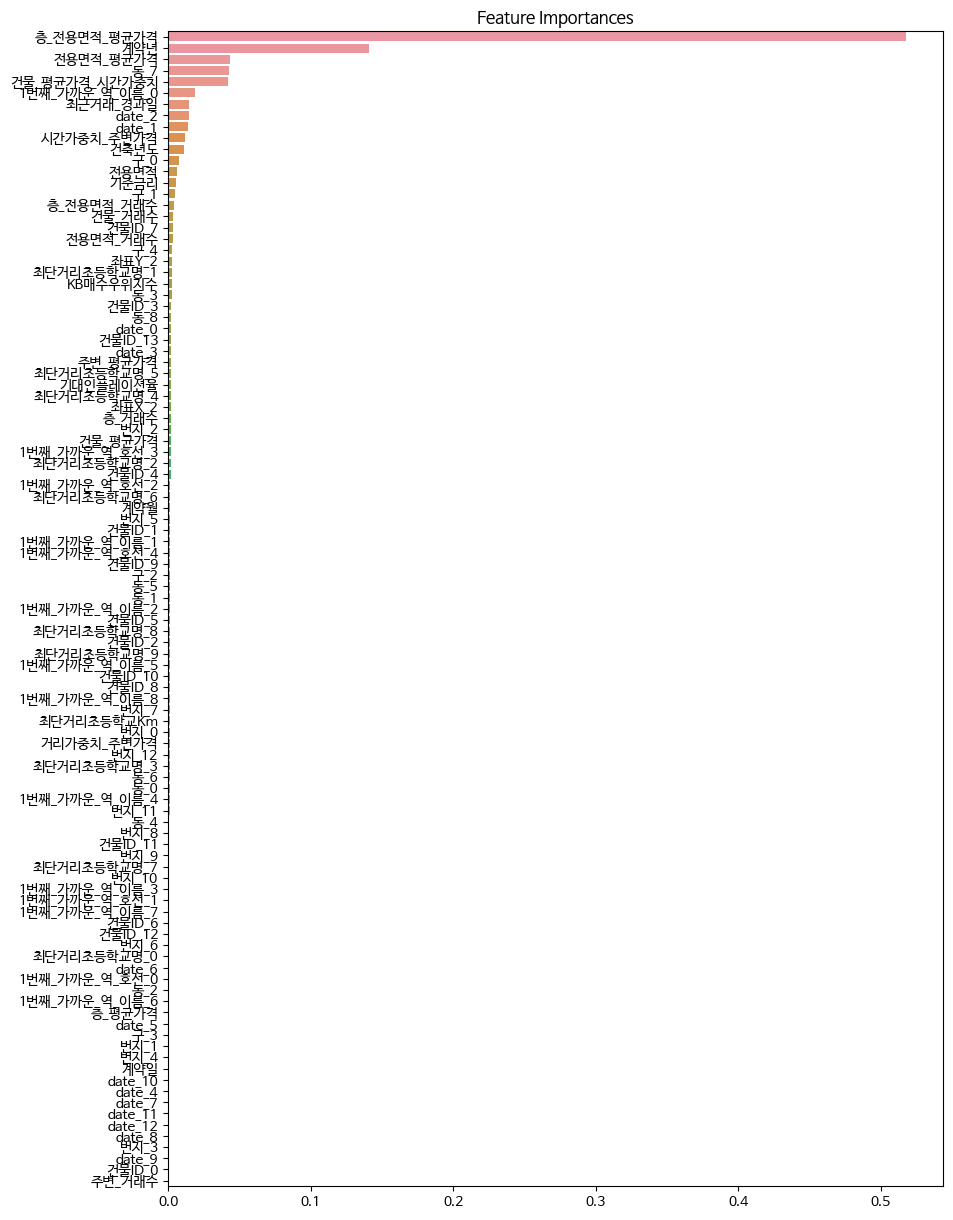

In [280]:
if 'XGBoost' in models:
    importances = pd.Series(models['XGBoost'].feature_importances_, index=list(X_train.columns))
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,15))
    plt.title("Feature Importances")
    sns.barplot(x=importances, y=importances.index)
    plt.show()

In [281]:
# 가중치 기반 앙상블 (선택사항)
# 각 모델의 성능에 따라 가중치를 조정할 수 있습니다
weights = {
    'RandomForest': 0.9,
    'GradientBoosting': 0.025,
    'LightGBM': 0.025,
    'XGBoost': 0.025,
    'LinearRegression': 0.025
}

In [282]:
# 앙상블 (평균) 예측
if IS_USE_WEIGHT:
    ensemble_pred_train = np.mean([weights[name] * pred for name, pred in pred_train.items()], axis=0)
    
    if IS_USE_VALID:
        ensemble_pred_valid = np.mean([weights[name] * pred for name, pred in pred_valid.items()], axis=0)
else:
    ensemble_pred_train = np.mean([pred for pred in pred_train.values()], axis=0)
    if IS_USE_VALID:
        ensemble_pred_valid = np.mean([pred for pred in pred_valid.values()], axis=0)

In [283]:
# 개별 모델 성능 평가
for name, pred in pred_train.items():
    mse = mean_squared_error(y_train, pred)
    mae = mean_absolute_error(y_train, pred)
    r2 = r2_score(y_train, pred)
    print(f"[Train] {name} - RMSE: {np.sqrt(mse):.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

for name, pred in pred_valid.items():
    mse = mean_squared_error(y_valid, pred)
    mae = mean_absolute_error(y_valid, pred)
    r2 = r2_score(y_valid, pred)
    print(f"[Valid] {name} - RMSE: {np.sqrt(mse):.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

[Train] LightGBM - RMSE: 2307.9093, MAE: 1543.5223, R2: 0.9975
[Train] XGBoost - RMSE: 2569.9382, MAE: 1722.9407, R2: 0.9969
[Valid] LightGBM - RMSE: 4929.9645, MAE: 2362.1834, R2: 0.9888
[Valid] XGBoost - RMSE: 5227.5741, MAE: 2533.4789, R2: 0.9874


In [284]:
# 앙상블 모델 성능 평가
ensemble_mse_train = mean_squared_error(y_train, ensemble_pred_train)
ensemble_mae_train = mean_absolute_error(y_train, ensemble_pred_train)
ensemble_r2_train = r2_score(y_train, ensemble_pred_train)
print(f"[Train] Ensemble - RMSE: {np.sqrt(ensemble_mse_train):.4f}, R2: {ensemble_r2_train:.4f}, MAE: {ensemble_mae_train:.4f}")

if IS_USE_VALID:
    ensemble_mse_valid = mean_squared_error(y_valid, ensemble_pred_valid)
    ensemble_mae_valid = mean_absolute_error(y_valid, ensemble_pred_valid)
    ensemble_r2_valid = r2_score(y_valid, ensemble_pred_valid)
    print(f"[Valid] Ensemble - RMSE: {np.sqrt(ensemble_mse_valid):.4f}, R2: {ensemble_r2_valid:.4f}, MAE: {ensemble_mae_valid:.4f}")

[Train] Ensemble - RMSE: 2358.2534, R2: 0.9974, MAE: 1570.9575
[Valid] Ensemble - RMSE: 4917.5402, R2: 0.9889, MAE: 2353.0437


In [285]:
def evaluate_model_fit(train_rmse, val_rmse, threshold=0.1):
    """
    모델의 성능을 평가하고 오버피팅/언더피팅 여부를 판단합니다.
    
    :param train_rmse: 훈련 데이터의 RMSE
    :param val_rmse: 검증 데이터의 RMSE
    :param threshold: 오버피팅/언더피팅을 판단하는 임계값 (기본값: 0.1)
    :return: 평가 결과 문자열, 상태
    """
    relative_diff = (val_rmse - train_rmse) / train_rmse

    if relative_diff > threshold:
        return f"오버피팅 징후가 있습니다. (차이: {relative_diff:.4f})", "오버피팅"
    elif relative_diff < -threshold:
        return f"언더피팅 징후가 있습니다. (차이: {relative_diff:.4f})", "언더피팅"
    else:
        return f"모델이 적절하게 피팅되었습니다. (차이: {relative_diff:.4f})", "적절"

if IS_USE_VALID:
    # 모델 평가
    evaluation_result, fit_status = evaluate_model_fit(np.sqrt(ensemble_mse_train), np.sqrt(ensemble_mse_valid), threshold=0.17)
    print(evaluation_result)
    
    # 해석 결과 출력
    print(f"\n실험 결과 해석:")
    if fit_status == "오버피팅":
        print("이번 실험은 오버피팅 되었습니다.")
        print("제안: 모델의 복잡도를 줄이거나, 규제를 강화하거나, 더 많은 훈련 데이터를 사용해 보세요.")
    elif fit_status == "언더피팅":
        print("이번 실험은 언더피팅 되었습니다.")
        print("제안: 모델의 복잡도를 높이거나, 더 많은 특성을 추가하거나, 특성 엔지니어링을 수행해 보세요.")
    else:
        print("이번 실험은 적절하게 학습되었습니다.")
        print("제안: 현재 모델이 잘 작동하고 있습니다. 필요하다면 미세 조정을 통해 성능을 더 개선해 볼 수 있습니다.")

오버피팅 징후가 있습니다. (차이: 1.0852)

실험 결과 해석:
이번 실험은 오버피팅 되었습니다.
제안: 모델의 복잡도를 줄이거나, 규제를 강화하거나, 더 많은 훈련 데이터를 사용해 보세요.


In [286]:
# R-squared 및 MAE 해석
def evaluate_r2(r2):
    print("\nR-squared 및 MAE 해석:")
    if r2 < 0.5:
        print("R-squared 값이 낮습니다. 모델이 데이터의 변동성을 잘 설명하지 못하고 있습니다.")
    elif r2 >= 0.5 and r2 < 0.7:
        print("R-squared 값이 중간 정도입니다. 모델이 데이터의 변동성을 어느 정도 설명하고 있습니다.")
    else:
        print("R-squared 값이 높습니다. 모델이 데이터의 변동성을 잘 설명하고 있습니다.")

def evaluate_mae_rmse(mae, rmse):
    if mae > rmse:
        print("MAE가 RMSE보다 큽니다. 이는 이상치의 영향이 크지 않음을 시사합니다.")
    else:
        print("RMSE가 MAE보다 큽니다. 이는 일부 큰 오차가 존재할 수 있음을 시사합니다.")

    print(f"\nMAE/RMSE 비율: {mae/rmse:.4f}")
    if mae/rmse > 0.9:
        print("MAE와 RMSE가 비슷합니다. 오차가 일관되게 분포되어 있을 가능성이 높습니다.")
    elif mae/rmse < 0.7:
        print("RMSE가 MAE보다 상당히 큽니다. 일부 큰 오차가 모델의 성능에 큰 영향을 미치고 있을 수 있습니다.")
    else:
        print("MAE와 RMSE의 차이가 적당합니다. 오차 분포가 적절해 보입니다.")    

def evaluate_additional_info(val_rmse, train_rmse, val_mae, train_mae, val_r2, train_r2):
    # 추가적인 정보 제공
    print(f"\n추가 정보:")
    print(f"Train RMSE와 Validation RMSE의 절대적 차이: {abs(val_rmse - train_rmse):.4f}")
    print(f"Train RMSE 대비 Validation RMSE의 비율: {val_rmse / train_rmse:.4f}")
    print(f"R-squared 차이 (Train - Validation): {train_r2 - val_r2:.4f}")
    print(f"MAE 차이 (Validation - Train): {val_mae - train_mae:.4f}")

if IS_USE_VALID:
    evaluate_r2(ensemble_r2_valid)
    evaluate_mae_rmse(ensemble_mae_valid, np.sqrt(ensemble_mse_valid))
    evaluate_additional_info(np.sqrt(ensemble_mse_valid), np.sqrt(ensemble_mse_train), 
                            ensemble_mae_valid, ensemble_mae_train, 
                            ensemble_r2_valid, ensemble_r2_train)


R-squared 및 MAE 해석:
R-squared 값이 높습니다. 모델이 데이터의 변동성을 잘 설명하고 있습니다.
RMSE가 MAE보다 큽니다. 이는 일부 큰 오차가 존재할 수 있음을 시사합니다.

MAE/RMSE 비율: 0.4785
RMSE가 MAE보다 상당히 큽니다. 일부 큰 오차가 모델의 성능에 큰 영향을 미치고 있을 수 있습니다.

추가 정보:
Train RMSE와 Validation RMSE의 절대적 차이: 2559.2868
Train RMSE 대비 Validation RMSE의 비율: 2.0852
R-squared 차이 (Train - Validation): 0.0085
MAE 차이 (Validation - Train): 782.0861


### 추론

In [287]:
pred_test = {}
for name, model in models.items():
    pred_test[name] = model.predict(df_test)

if 'LinearRegression' in pred_test: pred_test['LinearRegression'] = pred_test['LinearRegression'].flatten()

if IS_USE_WEIGHT:
    ensemble_pred_test = np.mean([weights[name] * pred for name, pred in pred_test.items()], axis=0)
else:
    ensemble_pred_test = np.mean([pred for pred in pred_test.values()], axis=0)

### Output 파일 저장

In [288]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(ensemble_pred_test.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)